In [1]:
import torch
from transformers import AutoTokenizer
from transformers.models.llama import LlamaForCausalLM
from transformers.models.llama.modeling_llama import LlamaMLP
from torch.utils.data import DataLoader
from datasets import load_dataset
from model import *

import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset


/home/jupyter/.local/lib/python3.10/site-packages/transformers/utils/hub.py:105: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(
2025-04-11 18:07:28.892647: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744394850.827441    8557 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744394851.319153    8557 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1744394855.300840    8557 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1744394855.300896    8557 comp

In [2]:
dtype = torch.bfloat16
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load tokenizer and base model
tokenizer = AutoTokenizer.from_pretrained("unsloth/Llama-3.2-1B-Instruct")
tokenizer.pad_token = tokenizer.eos_token

base_model = LlamaForCausalLM.from_pretrained("unsloth/Llama-3.2-1B-Instruct", torch_dtype=dtype)
base_model.to(device)
base_model.eval()


LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(128256, 2048, padding_idx=128004)
    (layers): ModuleList(
      (0-15): 16 x LlamaDecoderLayer(
        (self_attn): LlamaAttention(
          (q_proj): Linear(in_features=2048, out_features=2048, bias=False)
          (k_proj): Linear(in_features=2048, out_features=512, bias=False)
          (v_proj): Linear(in_features=2048, out_features=512, bias=False)
          (o_proj): Linear(in_features=2048, out_features=2048, bias=False)
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=2048, out_features=8192, bias=False)
          (up_proj): Linear(in_features=2048, out_features=8192, bias=False)
          (down_proj): Linear(in_features=8192, out_features=2048, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm((2048,), eps=1e-05)
        (post_attention_layernorm): LlamaRMSNorm((2048,), eps=1e-05)
      )
    )
    (norm): LlamaRMSNorm((2048,), eps=1e-0

In [3]:
speculator_head = PredictorHead(base_model.model.config)
speculator_head.load_state_dict(torch.load("new_nn_decoder_head1.pth"))
speculator_head.to(device, dtype=dtype)
specModel = TwoHeadModel(base_model, speculator_head)
specModel.to(device, dtype=dtype)
specModel.eval()

TwoHeadModel(
  (base_model): LlamaForCausalLM(
    (model): LlamaModel(
      (embed_tokens): Embedding(128256, 2048, padding_idx=128004)
      (layers): ModuleList(
        (0-15): 16 x LlamaDecoderLayer(
          (self_attn): LlamaAttention(
            (q_proj): Linear(in_features=2048, out_features=2048, bias=False)
            (k_proj): Linear(in_features=2048, out_features=512, bias=False)
            (v_proj): Linear(in_features=2048, out_features=512, bias=False)
            (o_proj): Linear(in_features=2048, out_features=2048, bias=False)
          )
          (mlp): LlamaMLP(
            (gate_proj): Linear(in_features=2048, out_features=8192, bias=False)
            (up_proj): Linear(in_features=2048, out_features=8192, bias=False)
            (down_proj): Linear(in_features=8192, out_features=2048, bias=False)
            (act_fn): SiLU()
          )
          (input_layernorm): LlamaRMSNorm((2048,), eps=1e-05)
          (post_attention_layernorm): LlamaRMSNorm((2048,), e

In [4]:
class PrefixTuningModel(nn.Module):
    def __init__(self, base_model, speculator_head, prefix_length):
        """
        Args:
            base_model: The pre-trained LlamaForCausalLM model.
            speculator_head: The additional head (predicting the second token).
            prefix_length: Number of trainable prefix tokens.
        """
        super(PrefixTuningModel, self).__init__()
        self.base_model = base_model
        self.prefix_length = prefix_length
        self.hidden_size = base_model.config.hidden_size
        self.prefix_embeddings = nn.Parameter(torch.randn(prefix_length, self.hidden_size, dtype=dtype))
        self.main_head = base_model.lm_head
        self.speculator_head = speculator_head

    def forward(self, input_ids, attention_mask=None):
        batch_size = input_ids.shape[0]
        input_embeds = self.base_model.model.embed_tokens(input_ids)  # shape: [batch, seq_len, hidden_size]
        prefix_embeds = self.prefix_embeddings.unsqueeze(0).expand(batch_size, -1, -1)
        concat_embeds = torch.cat([prefix_embeds, input_embeds], dim=1)
        if attention_mask is not None:
            prefix_mask = torch.ones(batch_size, self.prefix_length, device=attention_mask.device)
            attention_mask = torch.cat([prefix_mask, attention_mask], dim=1)
        outputs = self.base_model.model(inputs_embeds=concat_embeds, attention_mask=attention_mask)
        hidden_states = outputs.last_hidden_state  # shape: [batch, (prefix+seq_len), hidden_size]
        logits_main = self.main_head(hidden_states)
    
        batch_size, seq_len, _ = hidden_states.shape
        logits_speculator = self.speculator_head(hidden_states)
        return logits_main, logits_speculator

In [5]:
from torch.optim.lr_scheduler import LinearLR

prefix_length = 8

p_tuning_model = PrefixTuningModel(base_model, speculator_head, prefix_length)

p_tuning_model.to(device)

for param in p_tuning_model.base_model.parameters():
    param.requires_grad = False
for param in p_tuning_model.speculator_head.parameters():
    param.requires_grad = False

torch.manual_seed(11786353908476520374)
optimizer = optim.Adam(p_tuning_model.parameters(), lr=1e-3)

torch.manual_seed(11786353908476520374)
criterion = nn.CrossEntropyLoss()
torch.manual_seed(11786353908476520374)


In [6]:
dataset = load_dataset("mosaicml/instruct-v3", split="train[:8000]")

tokenizer = AutoTokenizer.from_pretrained("unsloth/Llama-3.2-1B-Instruct")
tokenizer.pad_token = tokenizer.eos_token

def collate_fn(batch):
    input_ids = [example["input_ids"] for example in batch]
    padded = tokenizer.pad({"input_ids": input_ids}, return_tensors="pt")
    return padded

Generating test split: 100%|██████████| 6807/6807 [00:00<00:00, 9789.23 examples/s]


In [13]:
# dataset = dataset.select(range(8000))

print(len(dataset))


8000


In [14]:
MAX_LENGTH = 128  # Max tokens per sequence
BATCH_SIZE = 8

class MathDataset(Dataset):
    def __init__(self, split="train"):
        if split == "train":
            self.data = dataset.select(range(0, int(0.9 * len(dataset))))
        else:
            self.data = dataset.select(range(int(0.9 * len(dataset)), len(dataset)))    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        item = self.data[idx]
        question = item['prompt']
        answer = item['response']

        # Tokenize input and label
        encoding = tokenizer(question, padding="max_length", truncation=True, max_length=MAX_LENGTH, return_tensors="pt")
        label_encoding = tokenizer(answer, padding="max_length", truncation=True, max_length=MAX_LENGTH, return_tensors="pt")

        input_ids = encoding["input_ids"].squeeze(0)  # Remove batch dim
        attention_mask = encoding["attention_mask"].squeeze(0)
        labels = label_encoding["input_ids"].squeeze(0)  # Labels are the tokenized answer

        return {"input_ids": input_ids, "attention_mask": attention_mask, "labels": labels}

train_dataset = MathDataset("train")
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

val_dataset = MathDataset("val")
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)


In [15]:
# trainable params count:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print("Trainable parameters:", count_parameters(p_tuning_model))

Trainable parameters: 16384


In [16]:
from IPython.display import clear_output
import warnings
import time
from datetime import timedelta
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt
import torch

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def learning_loop(
    model,
    optimizer,
    train_dataloader,
    val_dataloader,
    criterion,
    scheduler=None,
    min_lr=None,
    epochs=3,
    val_every=100,
    draw_every=50,
    separate_show=False,
    model_name=None,
    chkp_folder="./chkps",
    metric_names=None,
):

    device = next(model.parameters()).device
    dtype = next(model.parameters()).dtype

    losses = {'train': [], 'val': [], 'accuracy_val': [], 'lr': []}
    # lrs = []
    best_val_loss = np.Inf
    if metric_names is not None:
        metrics = defaultdict(list)
    start_time = time.monotonic()
    
    # [1, 1, 0, 0, 0, 1, 1, 0, 0, 0]
    idx = 0

    for epoch in range(1, epochs + 1):
        model.train()

        for batch_idx, batch in enumerate(train_dataloader):
            if idx % 10 == 0:
                print(idx)
            idx += 1

            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            attention_mask = attention_mask.to(dtype=dtype)

            optimizer.zero_grad()

            model_logits_main, model_logits_speculator = model(input_ids, attention_mask)

            seq_length = input_ids.shape[1]
            model_logits_main = model_logits_main[:, -seq_length:, :]
            model_logits_speculator = model_logits_speculator[:, -seq_length:-1, :]

            model_loss_main = criterion(
                model_logits_main.contiguous().view(-1, model_logits_main.size(-1)),
                labels.view(-1)
            )
            model_loss_head = criterion(
                model_logits_speculator.contiguous().view(-1, model_logits_speculator.size(-1)),
                labels[:, 1:].reshape(-1)
            )

            model_loss_main.backward()
            
            optimizer.step()
            scheduler.step()

            
            current_lr = optimizer.param_groups[0]['lr']
            losses['lr'].append(current_lr)

            losses['train'].append(model_loss_main.item())

            # validation
            if idx % val_every == 0:
                model.eval()

                avg_loss_val = 0.0
                
                agree = 0
                total = 0

                with torch.no_grad():
                    for idx_val, batch in enumerate(val_dataloader):
                        if idx_val == 10:
                            break

                        input_ids = batch["input_ids"].to(device)
                        attention_mask = batch["attention_mask"].to(device)
                        labels = batch["labels"].to(device)

                        attention_mask = attention_mask.to(dtype=dtype)

                        model_logits_main_val, _ = model(input_ids, attention_mask)

                        seq_length = input_ids.shape[1]
                        model_logits_main_val = model_logits_main_val[:, -seq_length:, :]

                        val_loss = criterion(
                            model_logits_main_val.contiguous().view(-1, model_logits_main_val.size(-1)),
                            labels.view(-1)
                        ).item()
                        
                        avg_loss_val += val_loss
                        
                        #accuracy computation
                        preds = torch.argmax(model_logits_main_val, dim=-1)
                        
                        agree += (preds == labels).sum().item()
                        total += preds.numel()
                        

                avg_loss_val /= 10

                losses['val'].append(avg_loss_val)
                
                losses['accuracy_val'].append(agree / total if total > 0 else 0)

                torch.cuda.empty_cache()

                model.train()

            # plotting
            if idx % draw_every == 0:
                clear_output(True)
                plt.clf()
                plt.figure(figsize=(10, 5))

                plt.subplot(2, 2, 1)
                plt.plot(losses['train'], label='train_loss')
                plt.xlabel('Iter')
                plt.ylabel('Loss')
                plt.title('Training Losses')
                plt.legend()
                plt.grid(True)

                plt.subplot(2, 2, 2)
                plt.plot(losses['val'], label='val_loss')
                plt.xlabel('Iter')
                plt.ylabel('Loss')
                plt.title('Validation Losses')
                plt.legend()
                plt.grid(True)

                
                plt.subplot(2, 2, 3)
                plt.plot(losses['accuracy_val'], label='accuracy_val')
                plt.xlabel('Iter')
                plt.ylabel('accuracy')
                plt.title('Validation accuracy')
                plt.legend()
                plt.grid(True)          
                
                plt.subplot(2, 2, 4)
                plt.plot(losses['lr'], label='lr')
                plt.xlabel('Iter')
                plt.ylabel('lr')
                plt.title('learning_rate')
                plt.legend()
                plt.grid(True)

                plt.tight_layout()
                plt.show()

    return losses


In [17]:
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.optim.lr_scheduler import LinearLR


num_epochs = 4

total_steps = num_epochs * len(train_dataloader)  # Total training steps

scheduler = CosineAnnealingLR(optimizer, T_max=total_steps, eta_min=0)


In [18]:
print(total_steps)

3600


<Figure size 640x480 with 0 Axes>

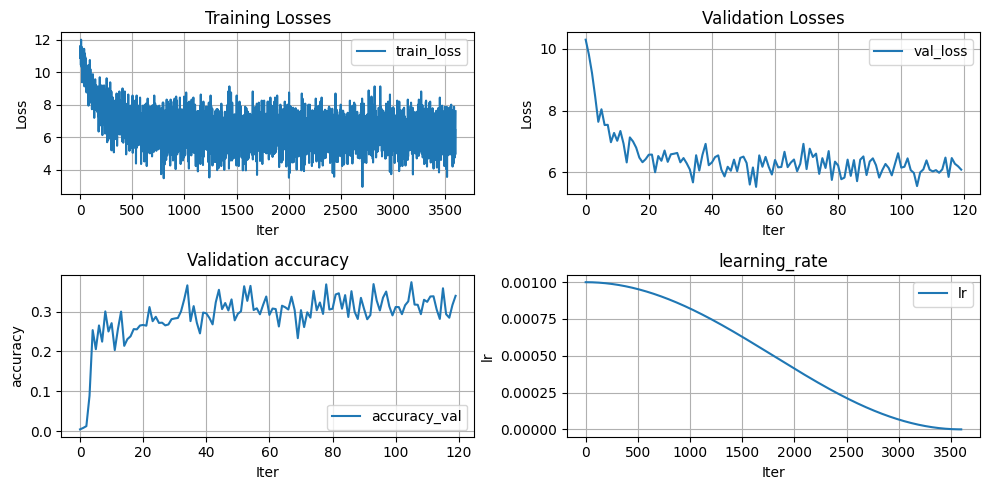

In [19]:
# from torch.optim.lr_scheduler import LinearLR  # Corrected import
import numpy as np

losses = learning_loop(
    p_tuning_model,
    optimizer,
    train_dataloader,
    val_dataloader,
    nn.CrossEntropyLoss(),
    scheduler=scheduler,
    min_lr=None,
    epochs=num_epochs,
    val_every=30,
    draw_every=40,
    separate_show=False,
    model_name=None,
    chkp_folder="./chkps",
    metric_names=None,
)



In [20]:
print(losses['train'])

[10.875, 11.5625, 10.9375, 11.625, 11.1875, 11.0625, 11.5, 10.6875, 10.4375, 11.375, 12.0, 10.9375, 11.4375, 11.0625, 11.5625, 10.3125, 10.75, 10.6875, 10.8125, 11.375, 9.375, 10.875, 10.375, 10.5, 11.0, 10.8125, 10.0625, 10.3125, 11.4375, 10.0, 10.4375, 11.0625, 10.5, 10.25, 10.0625, 10.1875, 10.125, 10.5625, 10.3125, 11.4375, 10.5, 11.1875, 9.125, 9.875, 10.5, 9.5, 10.5625, 10.3125, 11.0, 10.5, 10.0625, 10.5625, 10.75, 10.875, 10.4375, 9.375, 9.625, 9.75, 9.9375, 10.1875, 10.0625, 9.625, 8.75, 9.8125, 9.8125, 9.75, 10.125, 9.75, 8.9375, 9.8125, 9.3125, 9.0625, 10.0, 9.0625, 9.5, 9.9375, 9.5, 9.25, 9.875, 9.5625, 10.4375, 7.9375, 8.5625, 9.375, 9.0, 9.1875, 9.875, 9.4375, 9.0625, 8.9375, 10.0625, 8.1875, 8.8125, 9.0625, 10.75, 8.125, 8.5625, 9.75, 8.625, 10.1875, 9.5, 9.25, 9.5, 8.3125, 8.1875, 8.1875, 8.5, 9.25, 8.375, 9.5625, 9.3125, 9.5625, 8.3125, 9.0625, 7.71875, 9.375, 8.5625, 7.78125, 8.8125, 8.5625, 8.125, 9.75, 8.5, 9.875, 8.5, 9.4375, 9.25, 8.25, 8.1875, 8.6875, 8.625, 8.687

In [21]:
print(losses['val'])

[10.29375, 9.81875, 9.21875, 8.4625, 7.6375, 8.04375, 7.534375, 7.540625, 6.978125, 7.278125, 7.025, 7.340625, 6.93125, 6.325, 7.134375, 7.003125, 6.803125, 6.48125, 6.33125, 6.43125, 6.575, 6.578125, 6.00625, 6.53125, 6.378125, 6.709375, 6.34375, 6.5875, 6.60625, 6.63125, 6.328125, 6.465625, 6.2984375, 6.096875, 5.678125, 6.55625, 6.0625, 6.56875, 6.925, 6.234375, 6.325, 6.496875, 6.553125, 6.0875, 5.871875, 6.184375, 6.05625, 6.415625, 6.040625, 6.471875, 6.5125, 6.30625, 5.609375, 6.1625, 5.534375, 6.553125, 6.184375, 6.503125, 6.184375, 5.934375, 6.403125, 6.165625, 6.178125, 6.66875, 6.171875, 6.31875, 6.41875, 6.040625, 6.28125, 6.925, 6.109375, 6.76875, 6.5, 6.609375, 5.953125, 6.4625, 6.1453125, 6.690625, 5.759375, 6.35, 6.225, 5.78125, 5.834375, 6.415625, 5.8890625, 6.4, 5.71875, 6.4125, 6.51875, 5.915625, 6.353125, 6.45625, 6.234375, 5.834375, 6.078125, 6.275, 6.146875, 5.90625, 6.271875, 6.621875, 6.15625, 6.184375, 6.45625, 6.075, 5.984375, 5.559375, 6.003125, 6.1, 6.390625

In [22]:
print(losses['accuracy_val'])

[0.00498046875, 0.00859375, 0.0130859375, 0.0890625, 0.25341796875, 0.2056640625, 0.26513671875, 0.224609375, 0.30029296875, 0.25, 0.2708984375, 0.203515625, 0.2560546875, 0.2998046875, 0.2140625, 0.230859375, 0.237890625, 0.25595703125, 0.25537109375, 0.2650390625, 0.26640625, 0.26455078125, 0.31123046875, 0.27578125, 0.28681640625, 0.271484375, 0.2720703125, 0.26533203125, 0.267578125, 0.280859375, 0.2826171875, 0.28388671875, 0.30048828125, 0.3302734375, 0.36552734375, 0.2759765625, 0.31357421875, 0.2720703125, 0.24521484375, 0.2974609375, 0.2955078125, 0.28369140625, 0.26787109375, 0.323046875, 0.35439453125, 0.3060546875, 0.3212890625, 0.30263671875, 0.33037109375, 0.2779296875, 0.2943359375, 0.3005859375, 0.36328125, 0.32666015625, 0.36416015625, 0.3037109375, 0.30810546875, 0.29306640625, 0.31650390625, 0.33759765625, 0.29150390625, 0.30751953125, 0.30615234375, 0.26259765625, 0.31455078125, 0.3107421875, 0.30498046875, 0.337109375, 0.30361328125, 0.23330078125, 0.30341796875, 0

In [23]:
print(losses['lr'])

[0.0009999998096141248, 0.0009999992384566439, 0.0009999982865279923, 0.0009999969538288952, 0.0009999952403603673, 0.0009999931461237134, 0.0009999906711205286, 0.0009999878153526974, 0.000999984578822395, 0.0009999809615320856, 0.0009999769634845247, 0.0009999725846827562, 0.0009999678251301153, 0.0009999626848302262, 0.0009999571637870038, 0.0009999512620046524, 0.0009999449794876665, 0.0009999383162408305, 0.0009999312722692188, 0.0009999238475781958, 0.0009999160421734156, 0.0009999078560608222, 0.00099989928924665, 0.0009998903417374229, 0.0009998810135399547, 0.0009998713046613494, 0.0009998612151090004, 0.0009998507448905917, 0.0009998398940140967, 0.0009998286624877787, 0.0009998170503201912, 0.0009998050575201773, 0.00099979268409687, 0.0009997799300596921, 0.0009997667954183566, 0.000999753280182866, 0.0009997393843635127, 0.0009997251079708791, 0.0009997104510158369, 0.0009996954135095483, 0.000999679995463465, 0.0009996641968893286, 0.0009996480177991702, 0.000999631458205